In [0]:
%pip install bokeh

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
clinical_data_date = 2021

clinicial_trial_data_path = "/FileStore/tables/clinicaltrial_{clinical_data_date}.csv".format(clinical_data_date=clinical_data_date)
mesh_data_path = '/FileStore/tables/mesh.csv'
pharma_data_path = '/FileStore/tables/pharma.csv'


clinical_data_df = spark.read.options(header=True, delimiter='|', inferSchema=True).csv(clinicial_trial_data_path)
mesh_data_df = spark.read.options(header=True, delimiter=',', inferSchema=True).csv(mesh_data_path)
pharma_data_df = spark.read.options(header=True, delimiter=',', inferSchema=True).csv(pharma_data_path)

In [0]:
from pyspark.sql.functions import col, explode, split
import pandas as pd

In [0]:
# 1

clinical_data_df.distinct().count()

Out[3]: 387261

In [0]:
# 2

df1 = clinical_data_df.filter(clinical_data_df.Type.isNotNull())
df2 = df1.groupby("Type").count().orderBy("count", ascending=False)
df2.show(4)

+--------------------+------+
|                Type| count|
+--------------------+------+
|      Interventional|301472|
|       Observational| 77540|
|Observational [Pa...|  8180|
|     Expanded Access|    69|
+--------------------+------+



In [0]:
# 3

df1 = clinical_data_df.filter(clinical_data_df.Conditions.isNotNull())
df2 = df1.withColumn('Conditions',explode(split(df1.Conditions,','))).groupby("Conditions").count().orderBy("count", ascending=False)
df2.show(5)

+-----------------+-----+
|       Conditions|count|
+-----------------+-----+
|        Carcinoma|13389|
|Diabetes Mellitus|11080|
|        Neoplasms| 9371|
| Breast Neoplasms| 8640|
|         Syndrome| 8032|
+-----------------+-----+
only showing top 5 rows



In [0]:
# 4

df1 = clinical_data_df.filter(clinical_data_df.Conditions.isNotNull())
df2 = df1.withColumn('Conditions', explode(split(df1.Conditions, ','))).select('Conditions')

mdf1 = mesh_data_df.withColumn('spTree', split(mesh_data_df.tree, '\.')[0]).select('term', 'spTree')

jointdf1 = df2.join(mdf1, df2.Conditions==mdf1.term)
jointdf2 = jointdf1.groupby("spTree").count().orderBy("count", ascending=False)
jointdf2.select(col('spTree').alias('root'), col('count')).show(5)

+----+------+
|root| count|
+----+------+
| C04|143994|
| C23|136079|
| C01|106674|
| C14| 94523|
| C10| 92310|
+----+------+
only showing top 5 rows



In [0]:
# 5

pharma_companies = [row[0] for row in pharma_data_df.select('Parent_Company').collect()]

df1 = clinical_data_df.filter(clinical_data_df.Sponsor.isNotNull())
df2=df1.filter(~df1.Sponsor.isin(pharma_companies)).select('Sponsor').groupby("Sponsor").count().orderBy("count", ascending=False)
df2.show(10, truncate=False)

+---------------------------------------+-----+
|Sponsor                                |count|
+---------------------------------------+-----+
|National Cancer Institute (NCI)        |3218 |
|M.D. Anderson Cancer Center            |2414 |
|Assistance Publique - Hôpitaux de Paris|2369 |
|Mayo Clinic                            |2300 |
|Merck Sharp & Dohme Corp.              |2243 |
|Assiut University                      |2154 |
|Novartis Pharmaceuticals               |2088 |
|Massachusetts General Hospital         |1971 |
|Cairo University                       |1928 |
|Hoffmann-La Roche                      |1828 |
+---------------------------------------+-----+
only showing top 10 rows



In [0]:
# 6
df1 = clinical_data_df.filter(clinical_data_df.Status=='Completed').withColumn('months', split(clinical_data_df.Completion, ' ')[0]).withColumn('year', split(clinical_data_df.Completion, ' ')[1])

df2 = df1.filter(df1.year==clinical_data_date).select(df1.months).groupby("months").count()
df2.show()

+------+-----+
|months|count|
+------+-----+
|   Oct|  187|
|   Sep|  528|
|   Aug|  700|
|   May|  984|
|   Jun| 1094|
|   Feb|  934|
|   Mar| 1227|
|   Jan| 1131|
|   Apr|  967|
|   Jul|  819|
+------+-----+



In [0]:
# Visualization using Bokeh

from bokeh.io import output_file, show
from bokeh.plotting import figure
from bokeh.embed import file_html
from bokeh.resources import CDN

panda_frame = df2.toPandas()

output_file("bars.html")

p = figure(x_range=panda_frame['months'].tolist(), height=250,  title="Clinical Trials each month",
           toolbar_location=None, plot_height=350)

p.vbar(x=panda_frame['months'].tolist(), top=panda_frame['count'].tolist(), width=0.9)

p.xgrid.grid_line_color = None
p.y_range.start = 0

html = file_html(p, CDN, "bar")
displayHTML(html)

<!DOCTYPE html>
 
 
 
 
 
 bar

Out[10]: <AxesSubplot:xlabel='months'>

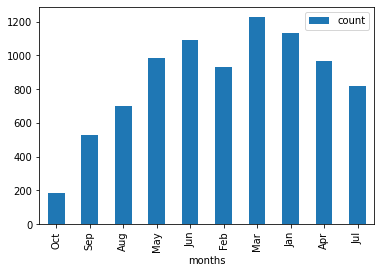

In [0]:
# Visualization using MatPlotlib

df2.toPandas().plot.bar(x='months',y='count')

Out[11]: <AxesSubplot:xlabel='months'>

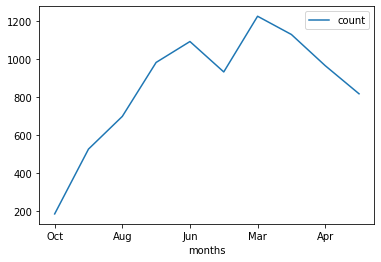

In [0]:
# Second visualization using MatPlotlib

df2.toPandas().plot(x='months',y='count')